In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
import torch.optim as optim
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from torchvision import datasets
from torch.utils.data import DataLoader

from torchvision import models
from torchvision.transforms import Compose, Resize, CenterCrop, RandomCrop, RandomHorizontalFlip, RandomVerticalFlip, Normalize, ToTensor

from fl_g13.config import RAW_DATA_DIR
from fl_g13.modeling import train, eval, save, load, backup, load_loss_and_accuracies, save_loss_and_accuracy
from fl_g13.dataset import train_test_split

from fl_g13.architectures import BaseDino
from fl_g13.editing import SparseSGDM


2025-05-01 19:49:58.084 | INFO     | fl_g13.config:<module>:11 - PROJ_ROOT path is: /home/massimiliano/Projects/fl-g13


In [3]:
# Define preprocessing pipeline
train_transform = Compose([
    Resize(256), # CIFRA100 is originally 32x32
    RandomCrop(224), # But Dino works on 224x224
    RandomHorizontalFlip(),
    ToTensor(),
    #Normalize(mean=[0.5071, 0.4866, 0.4409], std=[0.2673, 0.2564, 0.2762]), # CIFRAR100 Train stats
    Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # Use ImageNet stats
])

eval_transform = Compose([
    Resize(256), # CIFRA100 is originally 32x32
    CenterCrop(224), # But Dino works on 224x224
    ToTensor(),
    #Normalize(mean=[0.5071, 0.4866, 0.4409], std=[0.2673, 0.2564, 0.2762]), # CIFRAR100 Train stats
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Use ImageNet stats
])

cifar100_train = datasets.CIFAR100(root=RAW_DATA_DIR, train=True, download=True, transform=train_transform)
cifar100_test = datasets.CIFAR100(root=RAW_DATA_DIR, train=False, download=True, transform=eval_transform)

train_dataset, val_dataset = train_test_split(cifar100_train, 0.8, random_state=None)
test_dataset = cifar100_test

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 40000
Validation dataset size: 10000
Test dataset size: 10000


In [4]:
# Move to CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Settings
CHECKPOINT_DIR = "/home/massimiliano/Projects/fl-g13/checkpoints"
name = "alakazam"
start_epoch=1
num_epochs=80
save_every=5
backup_every=20

# Model Hyper-parameters
head_layers=3
head_hidden_size=512
dropout_rate=0.0
unfreeze_blocks=1

# Training Hyper-parameters
batch_size=128
lr=1e-3
momentum=0.9
weight_decay=5e-4
T_0=16
T_mult=2
eta_min=1e-5

# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model
model = BaseDino(
    head_layers=head_layers, 
    head_hidden_size=head_hidden_size, 
    dropout_rate=dropout_rate, 
    unfreeze_blocks=unfreeze_blocks
    )
model.to(device)

# Optimizer, scheduler, and loss function
optimizer = SGD(
    model.parameters(), 
    lr=lr,
    momentum=momentum,
    weight_decay=weight_decay
    )
scheduler = CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=T_0, 
    T_mult=T_mult, 
    eta_min=eta_min
    )
criterion = CrossEntropyLoss()

all_training_losses=[]       # Pre-allocated list for training losses
all_validation_losses=[]       # Pre-allocated list for validation losses
all_training_accuracies=[]    # Pre-allocated list for training accuracies
all_validation_accuracies=[]    # Pre-allocated list for validation accuracies

# # Model loading (uncomment to properly overwrite)
# loading_epoch = 20
# model, start_epoch = load(
#     f"{CHECKPOINT_DIR}/BaseDino/{name}_BaseDino_epoch_{loading_epoch}.pth",
#     model_class=BaseDino,
#     device=device,
#     optimizer=optimizer,
#     scheduler=scheduler,
#     verbose=True
# )
# model.to(device)
# loaded_metrics = load_loss_and_accuracies(path=f"{CHECKPOINT_DIR}/BaseDino/{name}_BaseDino_epoch_{loading_epoch}.loss_acc.json")

# # Preallocated lists: if the training interrupts, it will still save their values (uncomment to properly load and overwrite)
# all_training_losses=loaded_metrics["train_loss"]       # Pre-allocated list for training losses
# all_validation_losses=loaded_metrics["val_loss"]       # Pre-allocated list for validation losses
# all_training_accuracies=loaded_metrics["train_acc"]    # Pre-allocated list for training accuracies
# all_validation_accuracies=loaded_metrics["val_acc"]    # Pre-allocated list for validation accuracies

print(f"\nModel: {model}")

Using device: cuda


Using cache found in /home/massimiliano/.cache/torch/hub/facebookresearch_dino_main



Model: BaseDino(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm):

In [5]:
# Get one batch of data from the test dataloader
data_iter = iter(test_dataloader)
images, labels = next(data_iter)

# Move the data to the same device as the model
images = images.to(device)

# Perform prediction
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Print the first prediction and its corresponding label
print(f"Predicted class: {predicted[0].item()}, True class: {labels[0].item()}")
print(f"Outputs shape: {outputs.shape}")

Predicted class: 98, True class: 49
Outputs shape: torch.Size([128, 100])


In [6]:
try:
    _, _, _, _ = train(
        checkpoint_dir=CHECKPOINT_DIR,
        name=name,
        start_epoch=start_epoch,
        num_epochs=num_epochs,
        save_every=save_every,
        backup_every=backup_every,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        verbose=1,
        all_training_losses=all_training_losses,
        all_validation_losses=all_validation_losses,
        all_training_accuracies=all_training_accuracies,
        all_validation_accuracies=all_validation_accuracies,
    )

except KeyboardInterrupt:
    print("Training interrupted manually.")

except Exception as e:
    print(f"Training stopped due to error: {e}")

Prefix/name for the model was provided: alakazam



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.63batch/s]


🚀 Epoch 1/80 (1.25%) Completed
	📊 Training Loss: 2.1512
	✅ Training Accuracy: 45.98%
	⏳ Elapsed Time: 86.27s | ETA: 6815.49s
	🕒 Completed At: 19:51


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.06batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.3468
	🎯 Validation Accuracy: 61.84%



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.57batch/s]


🚀 Epoch 2/80 (2.50%) Completed
	📊 Training Loss: 1.0555
	✅ Training Accuracy: 69.15%
	⏳ Elapsed Time: 87.57s | ETA: 6830.27s
	🕒 Completed At: 19:53


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.00batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0427
	🎯 Validation Accuracy: 70.15%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.61batch/s]


🚀 Epoch 3/80 (3.75%) Completed
	📊 Training Loss: 0.8053
	✅ Training Accuracy: 75.57%
	⏳ Elapsed Time: 86.70s | ETA: 6676.18s
	🕒 Completed At: 19:55


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.06batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9630
	🎯 Validation Accuracy: 71.88%



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.59batch/s]


🚀 Epoch 4/80 (5.00%) Completed
	📊 Training Loss: 0.6676
	✅ Training Accuracy: 79.25%
	⏳ Elapsed Time: 87.29s | ETA: 6633.95s
	🕒 Completed At: 19:56


Eval progress: 100%|██████████| 79/79 [00:20<00:00,  3.93batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9363
	🎯 Validation Accuracy: 72.98%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.64batch/s]


🚀 Epoch 5/80 (6.25%) Completed
	📊 Training Loss: 0.5437
	✅ Training Accuracy: 82.94%
	⏳ Elapsed Time: 86.05s | ETA: 6453.76s
	🕒 Completed At: 19:58


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.09batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9180
	🎯 Validation Accuracy: 74.46%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_5.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_5.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:24<00:00,  3.72batch/s]


🚀 Epoch 6/80 (7.50%) Completed
	📊 Training Loss: 0.4456
	✅ Training Accuracy: 85.94%
	⏳ Elapsed Time: 84.11s | ETA: 6224.02s
	🕒 Completed At: 20:00


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.09batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8751
	🎯 Validation Accuracy: 75.14%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.64batch/s]


🚀 Epoch 7/80 (8.75%) Completed
	📊 Training Loss: 0.3571
	✅ Training Accuracy: 88.84%
	⏳ Elapsed Time: 86.06s | ETA: 6282.09s
	🕒 Completed At: 20:02


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.08batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8851
	🎯 Validation Accuracy: 75.46%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.63batch/s]


🚀 Epoch 8/80 (10.00%) Completed
	📊 Training Loss: 0.2864
	✅ Training Accuracy: 91.16%
	⏳ Elapsed Time: 86.24s | ETA: 6209.01s
	🕒 Completed At: 20:03


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  3.98batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8775
	🎯 Validation Accuracy: 76.04%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.63batch/s]


🚀 Epoch 9/80 (11.25%) Completed
	📊 Training Loss: 0.2277
	✅ Training Accuracy: 93.14%
	⏳ Elapsed Time: 86.19s | ETA: 6119.84s
	🕒 Completed At: 20:05


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.06batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8681
	🎯 Validation Accuracy: 76.90%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.61batch/s]


🚀 Epoch 10/80 (12.50%) Completed
	📊 Training Loss: 0.1871
	✅ Training Accuracy: 94.70%
	⏳ Elapsed Time: 86.72s | ETA: 6070.58s
	🕒 Completed At: 20:07


Eval progress: 100%|██████████| 79/79 [00:21<00:00,  3.63batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8538
	🎯 Validation Accuracy: 77.51%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_10.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_10.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.59batch/s]


🚀 Epoch 11/80 (13.75%) Completed
	📊 Training Loss: 0.1520
	✅ Training Accuracy: 95.90%
	⏳ Elapsed Time: 87.13s | ETA: 6011.63s
	🕒 Completed At: 20:09


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.06batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8611
	🎯 Validation Accuracy: 77.28%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.60batch/s]


🚀 Epoch 12/80 (15.00%) Completed
	📊 Training Loss: 0.1319
	✅ Training Accuracy: 96.68%
	⏳ Elapsed Time: 86.94s | ETA: 5912.00s
	🕒 Completed At: 20:10


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.08batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8475
	🎯 Validation Accuracy: 77.88%



Training progress: 100%|██████████| 313/313 [01:28<00:00,  3.56batch/s]


🚀 Epoch 13/80 (16.25%) Completed
	📊 Training Loss: 0.1143
	✅ Training Accuracy: 97.33%
	⏳ Elapsed Time: 88.00s | ETA: 5896.30s
	🕒 Completed At: 20:12


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.05batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8544
	🎯 Validation Accuracy: 77.90%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.60batch/s]


🚀 Epoch 14/80 (17.50%) Completed
	📊 Training Loss: 0.1044
	✅ Training Accuracy: 97.65%
	⏳ Elapsed Time: 86.86s | ETA: 5732.84s
	🕒 Completed At: 20:14


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.09batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8556
	🎯 Validation Accuracy: 77.70%



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.65batch/s]


🚀 Epoch 15/80 (18.75%) Completed
	📊 Training Loss: 0.0965
	✅ Training Accuracy: 97.93%
	⏳ Elapsed Time: 85.64s | ETA: 5566.54s
	🕒 Completed At: 20:16


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  3.98batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8538
	🎯 Validation Accuracy: 77.95%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_15.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_15.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.63batch/s]


🚀 Epoch 16/80 (20.00%) Completed
	📊 Training Loss: 0.0924
	✅ Training Accuracy: 98.17%
	⏳ Elapsed Time: 86.16s | ETA: 5514.25s
	🕒 Completed At: 20:17


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.05batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8520
	🎯 Validation Accuracy: 78.07%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.64batch/s]


🚀 Epoch 17/80 (21.25%) Completed
	📊 Training Loss: 0.2471
	✅ Training Accuracy: 92.10%
	⏳ Elapsed Time: 86.04s | ETA: 5420.46s
	🕒 Completed At: 20:19


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.08batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9884
	🎯 Validation Accuracy: 74.62%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.62batch/s]


🚀 Epoch 18/80 (22.50%) Completed
	📊 Training Loss: 0.2446
	✅ Training Accuracy: 92.07%
	⏳ Elapsed Time: 86.51s | ETA: 5363.88s
	🕒 Completed At: 20:21


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.09batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9657
	🎯 Validation Accuracy: 75.28%



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.57batch/s]


🚀 Epoch 19/80 (23.75%) Completed
	📊 Training Loss: 0.1963
	✅ Training Accuracy: 93.72%
	⏳ Elapsed Time: 87.60s | ETA: 5343.81s
	🕒 Completed At: 20:23


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.06batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9646
	🎯 Validation Accuracy: 75.68%



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.56batch/s]


🚀 Epoch 20/80 (25.00%) Completed
	📊 Training Loss: 0.1613
	✅ Training Accuracy: 94.85%
	⏳ Elapsed Time: 87.99s | ETA: 5279.65s
	🕒 Completed At: 20:25


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  3.99batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9897
	🎯 Validation Accuracy: 75.83%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_20.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_20.loss_acc.json

Running backup for epoch 20
💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/backup/BaseDino/backup_20250501_202525_alakazam_BaseDino_epoch_20.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/backup/BaseDino/backup_20250501_202525_alakazam_BaseDino_epoch_20.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.64batch/s]


🚀 Epoch 21/80 (26.25%) Completed
	📊 Training Loss: 0.1357
	✅ Training Accuracy: 95.75%
	⏳ Elapsed Time: 85.92s | ETA: 5069.17s
	🕒 Completed At: 20:26


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.09batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9814
	🎯 Validation Accuracy: 76.49%



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.65batch/s]


🚀 Epoch 22/80 (27.50%) Completed
	📊 Training Loss: 0.1118
	✅ Training Accuracy: 96.60%
	⏳ Elapsed Time: 85.69s | ETA: 4969.96s
	🕒 Completed At: 20:28


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.08batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9964
	🎯 Validation Accuracy: 76.79%



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.58batch/s]


🚀 Epoch 23/80 (28.75%) Completed
	📊 Training Loss: 0.0915
	✅ Training Accuracy: 97.39%
	⏳ Elapsed Time: 87.38s | ETA: 4980.40s
	🕒 Completed At: 20:30


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.08batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9942
	🎯 Validation Accuracy: 76.79%



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.59batch/s]


🚀 Epoch 24/80 (30.00%) Completed
	📊 Training Loss: 0.0749
	✅ Training Accuracy: 97.95%
	⏳ Elapsed Time: 87.20s | ETA: 4882.93s
	🕒 Completed At: 20:32


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.05batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0042
	🎯 Validation Accuracy: 77.01%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.64batch/s]


🚀 Epoch 25/80 (31.25%) Completed
	📊 Training Loss: 0.0628
	✅ Training Accuracy: 98.28%
	⏳ Elapsed Time: 86.10s | ETA: 4735.61s
	🕒 Completed At: 20:33


Eval progress: 100%|██████████| 79/79 [00:20<00:00,  3.94batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0159
	🎯 Validation Accuracy: 77.16%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_25.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_25.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.62batch/s]


🚀 Epoch 26/80 (32.50%) Completed
	📊 Training Loss: 0.0571
	✅ Training Accuracy: 98.55%
	⏳ Elapsed Time: 86.56s | ETA: 4674.06s
	🕒 Completed At: 20:35


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.07batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0013
	🎯 Validation Accuracy: 77.52%



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.64batch/s]


🚀 Epoch 27/80 (33.75%) Completed
	📊 Training Loss: 0.0477
	✅ Training Accuracy: 98.86%
	⏳ Elapsed Time: 85.95s | ETA: 4555.32s
	🕒 Completed At: 20:37


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.10batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0081
	🎯 Validation Accuracy: 77.43%



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.66batch/s]


🚀 Epoch 28/80 (35.00%) Completed
	📊 Training Loss: 0.0372
	✅ Training Accuracy: 99.18%
	⏳ Elapsed Time: 85.58s | ETA: 4450.23s
	🕒 Completed At: 20:39


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.06batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0030
	🎯 Validation Accuracy: 77.83%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.63batch/s]


🚀 Epoch 29/80 (36.25%) Completed
	📊 Training Loss: 0.0318
	✅ Training Accuracy: 99.34%
	⏳ Elapsed Time: 86.31s | ETA: 4401.86s
	🕒 Completed At: 20:40


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.09batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9813
	🎯 Validation Accuracy: 78.05%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.62batch/s]


🚀 Epoch 30/80 (37.50%) Completed
	📊 Training Loss: 0.0271
	✅ Training Accuracy: 99.52%
	⏳ Elapsed Time: 86.44s | ETA: 4322.06s
	🕒 Completed At: 20:42


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.07batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9979
	🎯 Validation Accuracy: 77.88%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_30.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_30.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:28<00:00,  3.54batch/s]


🚀 Epoch 31/80 (38.75%) Completed
	📊 Training Loss: 0.0234
	✅ Training Accuracy: 99.58%
	⏳ Elapsed Time: 88.35s | ETA: 4328.98s
	🕒 Completed At: 20:44


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.01batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0145
	🎯 Validation Accuracy: 77.72%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.63batch/s]


🚀 Epoch 32/80 (40.00%) Completed
	📊 Training Loss: 0.0216
	✅ Training Accuracy: 99.62%
	⏳ Elapsed Time: 86.13s | ETA: 4134.37s
	🕒 Completed At: 20:46


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.00batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0061
	🎯 Validation Accuracy: 78.33%



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.67batch/s]


🚀 Epoch 33/80 (41.25%) Completed
	📊 Training Loss: 0.0186
	✅ Training Accuracy: 99.72%
	⏳ Elapsed Time: 85.29s | ETA: 4008.55s
	🕒 Completed At: 20:48


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.06batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9912
	🎯 Validation Accuracy: 78.61%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.60batch/s]


🚀 Epoch 34/80 (42.50%) Completed
	📊 Training Loss: 0.0173
	✅ Training Accuracy: 99.75%
	⏳ Elapsed Time: 86.86s | ETA: 3995.47s
	🕒 Completed At: 20:49


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.00batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0158
	🎯 Validation Accuracy: 78.41%



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.64batch/s]


🚀 Epoch 35/80 (43.75%) Completed
	📊 Training Loss: 0.0157
	✅ Training Accuracy: 99.81%
	⏳ Elapsed Time: 85.98s | ETA: 3868.94s
	🕒 Completed At: 20:51


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.09batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0041
	🎯 Validation Accuracy: 78.23%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_35.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_35.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.64batch/s]


🚀 Epoch 36/80 (45.00%) Completed
	📊 Training Loss: 0.0151
	✅ Training Accuracy: 99.76%
	⏳ Elapsed Time: 86.08s | ETA: 3787.32s
	🕒 Completed At: 20:53


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.02batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0087
	🎯 Validation Accuracy: 78.60%



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.60batch/s]


🚀 Epoch 37/80 (46.25%) Completed
	📊 Training Loss: 0.0139
	✅ Training Accuracy: 99.82%
	⏳ Elapsed Time: 87.01s | ETA: 3741.42s
	🕒 Completed At: 20:55


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.06batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0041
	🎯 Validation Accuracy: 78.89%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.60batch/s]


🚀 Epoch 38/80 (47.50%) Completed
	📊 Training Loss: 0.0134
	✅ Training Accuracy: 99.78%
	⏳ Elapsed Time: 86.87s | ETA: 3648.59s
	🕒 Completed At: 20:56


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.09batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0098
	🎯 Validation Accuracy: 78.39%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.64batch/s]


🚀 Epoch 39/80 (48.75%) Completed
	📊 Training Loss: 0.0122
	✅ Training Accuracy: 99.86%
	⏳ Elapsed Time: 86.04s | ETA: 3527.81s
	🕒 Completed At: 20:58


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  3.99batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9926
	🎯 Validation Accuracy: 79.03%



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.57batch/s]


🚀 Epoch 40/80 (50.00%) Completed
	📊 Training Loss: 0.0114
	✅ Training Accuracy: 99.89%
	⏳ Elapsed Time: 87.60s | ETA: 3503.83s
	🕒 Completed At: 21:00


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.14batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0097
	🎯 Validation Accuracy: 78.41%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_40.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_40.loss_acc.json

Running backup for epoch 40
💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/backup/BaseDino/backup_20250501_210044_alakazam_BaseDino_epoch_40.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/backup/BaseDino/backup_20250501_210044_alakazam_BaseDino_epoch_40.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.63batch/s]


🚀 Epoch 41/80 (51.25%) Completed
	📊 Training Loss: 0.0106
	✅ Training Accuracy: 99.90%
	⏳ Elapsed Time: 86.19s | ETA: 3361.60s
	🕒 Completed At: 21:02


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.01batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0020
	🎯 Validation Accuracy: 78.43%



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.64batch/s]


🚀 Epoch 42/80 (52.50%) Completed
	📊 Training Loss: 0.0099
	✅ Training Accuracy: 99.89%
	⏳ Elapsed Time: 85.92s | ETA: 3265.07s
	🕒 Completed At: 21:03


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.07batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9988
	🎯 Validation Accuracy: 78.57%



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.65batch/s]


🚀 Epoch 43/80 (53.75%) Completed
	📊 Training Loss: 0.0102
	✅ Training Accuracy: 99.91%
	⏳ Elapsed Time: 85.86s | ETA: 3176.85s
	🕒 Completed At: 21:05


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  3.97batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9877
	🎯 Validation Accuracy: 78.61%



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.67batch/s]


🚀 Epoch 44/80 (55.00%) Completed
	📊 Training Loss: 0.0101
	✅ Training Accuracy: 99.89%
	⏳ Elapsed Time: 85.33s | ETA: 3071.93s
	🕒 Completed At: 21:07


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.07batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0041
	🎯 Validation Accuracy: 78.86%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.62batch/s]


🚀 Epoch 45/80 (56.25%) Completed
	📊 Training Loss: 0.0097
	✅ Training Accuracy: 99.92%
	⏳ Elapsed Time: 86.47s | ETA: 3026.32s
	🕒 Completed At: 21:09


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.08batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0124
	🎯 Validation Accuracy: 78.95%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_45.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_45.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.62batch/s]


🚀 Epoch 46/80 (57.50%) Completed
	📊 Training Loss: 0.0097
	✅ Training Accuracy: 99.94%
	⏳ Elapsed Time: 86.45s | ETA: 2939.32s
	🕒 Completed At: 21:10


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.09batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0063
	🎯 Validation Accuracy: 78.80%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.64batch/s]


🚀 Epoch 47/80 (58.75%) Completed
	📊 Training Loss: 0.0094
	✅ Training Accuracy: 99.94%
	⏳ Elapsed Time: 86.03s | ETA: 2839.03s
	🕒 Completed At: 21:12


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.12batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0147
	🎯 Validation Accuracy: 78.80%



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.65batch/s]


🚀 Epoch 48/80 (60.00%) Completed
	📊 Training Loss: 0.0093
	✅ Training Accuracy: 99.91%
	⏳ Elapsed Time: 85.69s | ETA: 2742.11s
	🕒 Completed At: 21:14


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.12batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9947
	🎯 Validation Accuracy: 78.90%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.62batch/s]


🚀 Epoch 49/80 (61.25%) Completed
	📊 Training Loss: 0.0228
	✅ Training Accuracy: 99.52%
	⏳ Elapsed Time: 86.51s | ETA: 2681.92s
	🕒 Completed At: 21:16


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.05batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0542
	🎯 Validation Accuracy: 77.37%



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.64batch/s]


🚀 Epoch 50/80 (62.50%) Completed
	📊 Training Loss: 0.0303
	✅ Training Accuracy: 99.29%
	⏳ Elapsed Time: 85.99s | ETA: 2579.65s
	🕒 Completed At: 21:18


Eval progress: 100%|██████████| 79/79 [00:18<00:00,  4.18batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0655
	🎯 Validation Accuracy: 77.25%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_50.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_50.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.67batch/s]


🚀 Epoch 51/80 (63.75%) Completed
	📊 Training Loss: 0.0325
	✅ Training Accuracy: 99.23%
	⏳ Elapsed Time: 85.33s | ETA: 2474.43s
	🕒 Completed At: 21:19


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.08batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0770
	🎯 Validation Accuracy: 77.10%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.63batch/s]


🚀 Epoch 52/80 (65.00%) Completed
	📊 Training Loss: 0.0324
	✅ Training Accuracy: 99.28%
	⏳ Elapsed Time: 86.32s | ETA: 2416.97s
	🕒 Completed At: 21:21


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.08batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0666
	🎯 Validation Accuracy: 77.34%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.61batch/s]


🚀 Epoch 53/80 (66.25%) Completed
	📊 Training Loss: 0.0293
	✅ Training Accuracy: 99.36%
	⏳ Elapsed Time: 86.76s | ETA: 2342.56s
	🕒 Completed At: 21:23


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.09batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0775
	🎯 Validation Accuracy: 77.18%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.63batch/s]


🚀 Epoch 54/80 (67.50%) Completed
	📊 Training Loss: 0.0293
	✅ Training Accuracy: 99.32%
	⏳ Elapsed Time: 86.13s | ETA: 2239.35s
	🕒 Completed At: 21:25


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.07batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.1073
	🎯 Validation Accuracy: 76.82%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.62batch/s]


🚀 Epoch 55/80 (68.75%) Completed
	📊 Training Loss: 0.0281
	✅ Training Accuracy: 99.36%
	⏳ Elapsed Time: 86.58s | ETA: 2164.41s
	🕒 Completed At: 21:26


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.15batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0724
	🎯 Validation Accuracy: 77.32%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_55.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_55.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.60batch/s]


🚀 Epoch 56/80 (70.00%) Completed
	📊 Training Loss: 0.0284
	✅ Training Accuracy: 99.32%
	⏳ Elapsed Time: 87.03s | ETA: 2088.68s
	🕒 Completed At: 21:28


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.06batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0653
	🎯 Validation Accuracy: 77.79%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.62batch/s]


🚀 Epoch 57/80 (71.25%) Completed
	📊 Training Loss: 0.0254
	✅ Training Accuracy: 99.44%
	⏳ Elapsed Time: 86.51s | ETA: 1989.78s
	🕒 Completed At: 21:30


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.09batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0667
	🎯 Validation Accuracy: 77.69%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.62batch/s]


🚀 Epoch 58/80 (72.50%) Completed
	📊 Training Loss: 0.0215
	✅ Training Accuracy: 99.55%
	⏳ Elapsed Time: 86.48s | ETA: 1902.66s
	🕒 Completed At: 21:32


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.07batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0676
	🎯 Validation Accuracy: 77.53%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.62batch/s]


🚀 Epoch 59/80 (73.75%) Completed
	📊 Training Loss: 0.0233
	✅ Training Accuracy: 99.52%
	⏳ Elapsed Time: 86.53s | ETA: 1817.11s
	🕒 Completed At: 21:33


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  3.99batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0642
	🎯 Validation Accuracy: 78.04%



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.60batch/s]


🚀 Epoch 60/80 (75.00%) Completed
	📊 Training Loss: 0.0186
	✅ Training Accuracy: 99.65%
	⏳ Elapsed Time: 87.05s | ETA: 1740.97s
	🕒 Completed At: 21:35


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.01batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0779
	🎯 Validation Accuracy: 77.76%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_60.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_60.loss_acc.json

Running backup for epoch 60
💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/backup/BaseDino/backup_20250501_213558_alakazam_BaseDino_epoch_60.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/backup/BaseDino/backup_20250501_213558_alakazam_BaseDino_epoch_60.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.63batch/s]


🚀 Epoch 61/80 (76.25%) Completed
	📊 Training Loss: 0.0149
	✅ Training Accuracy: 99.77%
	⏳ Elapsed Time: 86.11s | ETA: 1636.18s
	🕒 Completed At: 21:37


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.09batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0787
	🎯 Validation Accuracy: 78.08%



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.59batch/s]


🚀 Epoch 62/80 (77.50%) Completed
	📊 Training Loss: 0.0148
	✅ Training Accuracy: 99.72%
	⏳ Elapsed Time: 87.10s | ETA: 1567.87s
	🕒 Completed At: 21:39


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.11batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0749
	🎯 Validation Accuracy: 77.86%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.64batch/s]


🚀 Epoch 63/80 (78.75%) Completed
	📊 Training Loss: 0.0125
	✅ Training Accuracy: 99.78%
	⏳ Elapsed Time: 86.05s | ETA: 1462.87s
	🕒 Completed At: 21:40


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.02batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0723
	🎯 Validation Accuracy: 78.14%



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.65batch/s]


🚀 Epoch 64/80 (80.00%) Completed
	📊 Training Loss: 0.0116
	✅ Training Accuracy: 99.83%
	⏳ Elapsed Time: 85.84s | ETA: 1373.46s
	🕒 Completed At: 21:42


Eval progress: 100%|██████████| 79/79 [00:20<00:00,  3.81batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.1064
	🎯 Validation Accuracy: 77.94%



Training progress: 100%|██████████| 313/313 [01:29<00:00,  3.51batch/s]


🚀 Epoch 65/80 (81.25%) Completed
	📊 Training Loss: 0.0113
	✅ Training Accuracy: 99.86%
	⏳ Elapsed Time: 89.23s | ETA: 1338.39s
	🕒 Completed At: 21:44


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.08batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0809
	🎯 Validation Accuracy: 78.08%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_65.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_65.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.62batch/s]


🚀 Epoch 66/80 (82.50%) Completed
	📊 Training Loss: 0.0108
	✅ Training Accuracy: 99.83%
	⏳ Elapsed Time: 86.35s | ETA: 1208.93s
	🕒 Completed At: 21:46


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.07batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0519
	🎯 Validation Accuracy: 78.74%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.60batch/s]


🚀 Epoch 67/80 (83.75%) Completed
	📊 Training Loss: 0.0100
	✅ Training Accuracy: 99.84%
	⏳ Elapsed Time: 86.97s | ETA: 1130.57s
	🕒 Completed At: 21:48


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.00batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0697
	🎯 Validation Accuracy: 78.70%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.61batch/s]


🚀 Epoch 68/80 (85.00%) Completed
	📊 Training Loss: 0.0088
	✅ Training Accuracy: 99.90%
	⏳ Elapsed Time: 86.69s | ETA: 1040.33s
	🕒 Completed At: 21:49


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.11batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0629
	🎯 Validation Accuracy: 78.12%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.64batch/s]


🚀 Epoch 69/80 (86.25%) Completed
	📊 Training Loss: 0.0079
	✅ Training Accuracy: 99.91%
	⏳ Elapsed Time: 86.09s | ETA: 947.04s
	🕒 Completed At: 21:51


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.01batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0538
	🎯 Validation Accuracy: 78.81%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.63batch/s]


🚀 Epoch 70/80 (87.50%) Completed
	📊 Training Loss: 0.0080
	✅ Training Accuracy: 99.89%
	⏳ Elapsed Time: 86.21s | ETA: 862.10s
	🕒 Completed At: 21:53


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.05batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0356
	🎯 Validation Accuracy: 78.85%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_70.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_70.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.61batch/s]


🚀 Epoch 71/80 (88.75%) Completed
	📊 Training Loss: 0.0078
	✅ Training Accuracy: 99.89%
	⏳ Elapsed Time: 86.63s | ETA: 779.70s
	🕒 Completed At: 21:55


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.07batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0583
	🎯 Validation Accuracy: 78.66%



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.68batch/s]


🚀 Epoch 72/80 (90.00%) Completed
	📊 Training Loss: 0.0072
	✅ Training Accuracy: 99.91%
	⏳ Elapsed Time: 85.01s | ETA: 680.11s
	🕒 Completed At: 21:56


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.11batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0584
	🎯 Validation Accuracy: 78.07%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.60batch/s]


🚀 Epoch 73/80 (91.25%) Completed
	📊 Training Loss: 0.0062
	✅ Training Accuracy: 99.93%
	⏳ Elapsed Time: 86.92s | ETA: 608.43s
	🕒 Completed At: 21:58


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.12batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0622
	🎯 Validation Accuracy: 78.62%



Training progress: 100%|██████████| 313/313 [01:24<00:00,  3.70batch/s]


🚀 Epoch 74/80 (92.50%) Completed
	📊 Training Loss: 0.0068
	✅ Training Accuracy: 99.92%
	⏳ Elapsed Time: 84.69s | ETA: 508.11s
	🕒 Completed At: 22:00


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.09batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0504
	🎯 Validation Accuracy: 78.58%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.60batch/s]


🚀 Epoch 75/80 (93.75%) Completed
	📊 Training Loss: 0.0062
	✅ Training Accuracy: 99.92%
	⏳ Elapsed Time: 86.95s | ETA: 434.77s
	🕒 Completed At: 22:02


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.14batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0468
	🎯 Validation Accuracy: 78.81%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_75.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_75.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.60batch/s]


🚀 Epoch 76/80 (95.00%) Completed
	📊 Training Loss: 0.0060
	✅ Training Accuracy: 99.94%
	⏳ Elapsed Time: 86.88s | ETA: 347.50s
	🕒 Completed At: 22:03


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.10batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0531
	🎯 Validation Accuracy: 78.63%



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.65batch/s]


🚀 Epoch 77/80 (96.25%) Completed
	📊 Training Loss: 0.0065
	✅ Training Accuracy: 99.89%
	⏳ Elapsed Time: 85.68s | ETA: 257.04s
	🕒 Completed At: 22:05


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.03batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0509
	🎯 Validation Accuracy: 78.73%



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.65batch/s]


🚀 Epoch 78/80 (97.50%) Completed
	📊 Training Loss: 0.0058
	✅ Training Accuracy: 99.95%
	⏳ Elapsed Time: 85.74s | ETA: 171.48s
	🕒 Completed At: 22:07


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  3.97batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0583
	🎯 Validation Accuracy: 78.72%



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.58batch/s]


🚀 Epoch 79/80 (98.75%) Completed
	📊 Training Loss: 0.0055
	✅ Training Accuracy: 99.94%
	⏳ Elapsed Time: 87.45s | ETA: 87.45s
	🕒 Completed At: 22:09


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  3.96batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0552
	🎯 Validation Accuracy: 78.76%



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.65batch/s]


🚀 Epoch 80/80 (100.00%) Completed
	📊 Training Loss: 0.0050
	✅ Training Accuracy: 99.95%
	⏳ Elapsed Time: 85.82s | ETA: 0.00s
	🕒 Completed At: 22:10


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.09batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0309
	🎯 Validation Accuracy: 78.89%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_80.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/alakazam_BaseDino_epoch_80.loss_acc.json

Running backup for epoch 80
💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/backup/BaseDino/backup_20250501_221117_alakazam_BaseDino_epoch_80.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/backup/BaseDino/backup_20250501_221117_alakazam_BaseDino_epoch_80.loss_acc.json



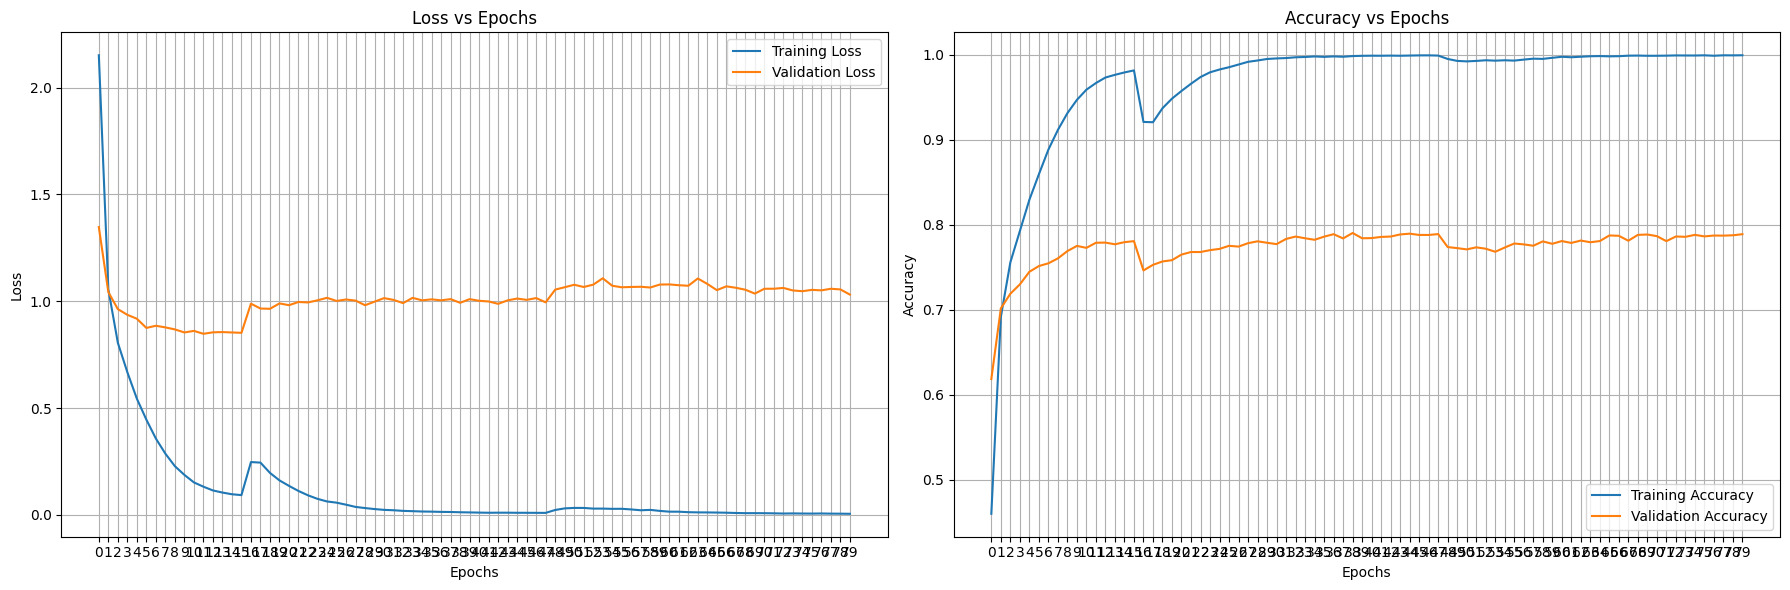

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot losses
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(all_training_losses, label='Training Loss')
plt.plot(all_validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid(True)  # Add grid
plt.xticks(range(len(all_training_losses)), rotation=0)  # Rotate ticks by 20 degrees

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(all_training_accuracies, label='Training Accuracy')
plt.plot(all_validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)  # Add grid
plt.xticks(range(len(all_training_accuracies)), rotation=0)  # Rotate ticks by 20 degrees

plt.tight_layout()
plt.show()

In [8]:
# Evaluate the model on the validation dataset
test_loss, test_accuracy, _ = eval(dataloader=test_dataloader, model=model, criterion=criterion)

print(
    f"🔍 Test Results:\n"
    f"\t📉 Test Loss: {test_loss:.4f}\n"
    f"\t🎯 Test Accuracy: {100 * test_accuracy:.2f}%"
)

Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.11batch/s]

🔍 Test Results:
	📉 Test Loss: 1.0089
	🎯 Test Accuracy: 79.33%
